In [1]:
# Import standard dependencies
import os
os.environ["OPENCV_VIDEOIO_MSMF_ENABLE_HW_TRANSFORMS"] = "0"
import cv2

import random
import numpy as np
from matplotlib import pyplot as plt

### Imports and environment setup
- Imports core libraries: `os`, `cv2` (OpenCV), `random`, `numpy`, and `matplotlib` for image handling, array ops, and visualization.
- Sets `OPENCV_VIDEOIO_MSMF_ENABLE_HW_TRANSFORMS=0` to avoid webcam decoding issues on Windows (MSMF backend).
- This cell prepares the environment for data collection, preprocessing, and visualization used throughout the notebook.

In [2]:
# Import tensorflow dependencies - Functional API
import tensorflow as tf

### TensorFlow import
- Imports TensorFlow (`tf`) to build and train the Siamese network using the Keras Functional API.
- Subsequent cells use `tf.data` for pipelines and `tf.keras` for the model and training loop.

In [3]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

### GPU memory growth (optional)
- Lists available GPUs and enables memory growth to prevent TensorFlow from pre-allocating all VRAM.
- Safe on single/multi-GPU setups; no effect if running on CPU.

In [4]:
# Setup paths
POS_PATH = os.path.join('data', 'positive')
NEG_PATH = os.path.join('data', 'negative')
ANC_PATH = os.path.join('data', 'anchor')

### Dataset paths
- Defines folder paths for three classes of images:
  - `anchor`: images of the target identity captured from webcam.
  - `positive`: more images of the same identity (also webcam-captured).
  - `negative`: images of other identities (e.g., from LFW dataset).
- These paths are used to build the `tf.data` pipeline later.

In [5]:
# Make the directories
#os.makedirs(POS_PATH)
#os.makedirs(NEG_PATH)
#os.makedirs(ANC_PATH)

### Directory creation (commented)
- Commands to create `data/positive`, `data/negative`, and `data/anchor` are shown but commented out.
- Uncomment and run once if these folders do not exist yet, or create them manually.

In [6]:

#for directory in os.listdir('lfw-deepfunneled'):
#   for file in os.listdir(os.path.join('lfw-deepfunneled', directory)):
#        EX_PATH = os.path.join('lfw-deepfunneled', directory, file)
#        NEW_PATH = os.path.join(NEG_PATH, file)
#        os.replace(EX_PATH, NEW_PATH)

### Populate negatives from LFW (commented)
- Illustrates how to move images from `lfw-deepfunneled/<person>/*` into `data/negative/`.
- Keep commented unless LFW is downloaded locally. Adjust paths as needed.

In [7]:
# Import uuid library to generate unique image names
import uuid
import cv2

### Unique filenames for captures
- Uses `uuid.uuid1()` to generate unique `.jpg` names when saving anchor/positive images from the webcam.
- Prevents overwriting and keeps the dataset organized.

In [8]:
os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))

'data\\anchor\\4a476ddc-2183-11f0-aa48-a8e2911e1ca5.jpg'

### Example capture path
- Demonstrates the final file path pattern for saved images in `ANC_PATH`.
- The placeholder `{uuid}.jpg` is replaced at runtime when capturing.

In [9]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()

    frame = frame[150:150+250,125:125+250,:]

    # Collect anchors 
    if cv2.waitKey(1) & 0XFF == ord('a'):
        # Create the unique file path 
        imgname = os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))
        # Write out anchor image
        cv2.imwrite(imgname, frame)
    
    # Collect positives
    if cv2.waitKey(1) & 0XFF == ord('p'):
        # Create the unique file path 
        imgname = os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1()))
        # Write out positive image
        cv2.imwrite(imgname, frame)
    
    cv2.imshow('Image Collection', frame)
    
    if cv2.waitKey(1) & 0XFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

### Webcam capture loop
- Opens camera `0`, crops a 250×250 region, and shows it live.
- Press `a` to save an anchor image; press `p` to save a positive image; press `q` to quit.
- Images are written into `data/anchor` and `data/positive` respectively.

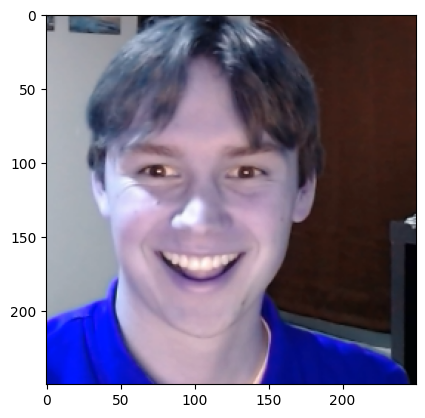

In [10]:
plt.imshow(frame)

### Preview a captured frame
- Displays the most recent `frame` for sanity-checking the crop and brightness.
- If colors look off, remember OpenCV reads in BGR; `plt.imshow` expects RGB (convert via `frame[..., ::-1]` if needed).

In [11]:
frame[:250,:250,:]

array([[[ 85,  90, 101],
        [ 37,  42,  53],
        [ 83,  87,  96],
        ...,
        [ 60,  33,  22],
        [ 59,  32,  22],
        [ 59,  31,  22]],

       [[ 91,  98, 110],
        [ 55,  62,  73],
        [ 81,  87,  97],
        ...,
        [ 59,  32,  21],
        [ 59,  31,  22],
        [ 60,  31,  22]],

       [[111, 119, 132],
        [ 77,  85,  98],
        [ 76,  83,  94],
        ...,
        [ 59,  31,  22],
        [ 60,  31,  22],
        [ 62,  31,  22]],

       ...,

       [[  0,  15, 171],
        [  0,  14, 173],
        [  0,  15, 174],
        ...,
        [  1,   3,   5],
        [  1,   3,   6],
        [  1,   3,   7]],

       [[  0,  13, 170],
        [  0,  14, 173],
        [  0,  14, 174],
        ...,
        [  0,   2,   4],
        [  1,   3,   6],
        [  1,   3,   6]],

       [[  0,  14, 169],
        [  0,  13, 172],
        [  0,  14, 173],
        ...,
        [  0,   2,   4],
        [  0,   2,   4],
        [  1,   3,   5]]

### Crop indexing sanity check
- Displays a slice of the `frame` array to validate crop dimensions and indexing.
- Useful when adjusting ROI coordinates.

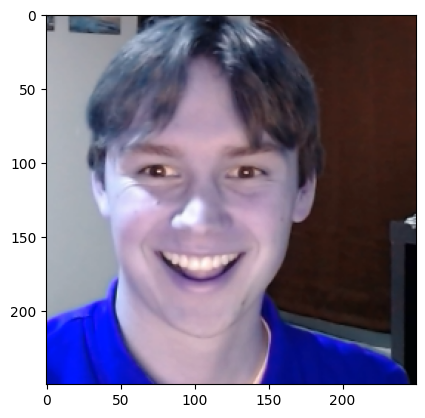

In [12]:
plt.imshow(frame)

### Second frame preview
- Another quick visual check after slicing. Ensure faces are centered and well-lit for better training data.

In [13]:
anchor = tf.data.Dataset.list_files(ANC_PATH+'\*.jpg').take(300)
positive = tf.data.Dataset.list_files(POS_PATH+'\*.jpg').take(300)
negative = tf.data.Dataset.list_files(NEG_PATH+'\*.jpg').take(300)

### Build file datasets
- Creates three `tf.data.Dataset` objects listing up to 300 JPGs for `anchor`, `positive`, and `negative`.
- Uses Windows path separator `\\*.jpg`. Adjust limits as your dataset grows.

In [14]:
dir_test = anchor.as_numpy_iterator()

### Peek at dataset entries
- Converts the `anchor` dataset to a NumPy iterator to inspect raw file paths.
- Handy for verifying the dataset points to the expected images.

In [15]:
print(dir_test.next())

b'data\\anchor\\5154f2a4-216d-11f0-8c8f-a8e2911e1ca5.jpg'


### Example listed file path
- Prints one path from the `anchor` dataset to confirm directory and pattern matching are correct.

In [16]:
#Pre Processing
def preproccess(file_path):
    # take image from file path
    byte_img = tf.io.read_file(file_path)
    #load image
    img = tf.io.decode_jpeg(byte_img)
    #resize to 100x100x3 and scaling image btween 0 and 1
    img = tf.image.resize(img, (100,100))
    img = img / 255.0
    return img

### Image preprocessing
- Reads JPEG bytes from a path, decodes to a tensor, resizes to 100×100, and scales to [0,1].
- This ensures consistent input size and normalization for the model.

In [17]:
img = preproccess('data\\anchor\\1233c739-216d-11f0-9a20-a8e2911e1ca5.jpg')

### Preprocess a sample image
- Runs `preproccess` on one anchor image to verify the function and file path are correct.

In [18]:
img.numpy().max()

1.0

### Inspect normalization
- Confirms the maximum value is ≤ 1.0 after scaling (expected for [0,1] range).

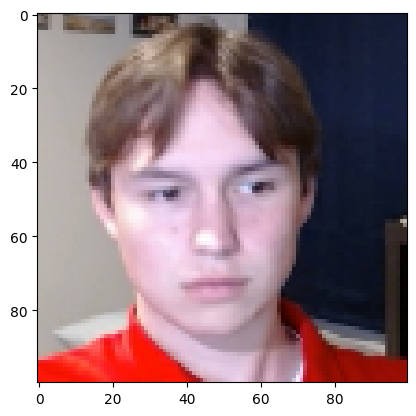

In [19]:
#processed image
plt.imshow(img)

### Visualize processed image
- Shows the resized, normalized image to verify the preprocessing pipeline visually.

In [20]:
# Create labelled Dataset
# create an anchor and positive array that has outputs 1 to show success
# create anchor and negative array with outputs 0 to show failure

positives = tf.data.Dataset.zip((anchor,positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor,negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

### Construct labeled pairs
- Zips `(anchor, positive, 1)` for genuine pairs and `(anchor, negative, 0)` for impostor pairs.
- Concatenates both to form the training dataset with labels.

In [21]:
samples = data.as_numpy_iterator()


### Inspect the paired dataset
- Converts `data` to an iterator to peek at the structure `(anchor_path, other_path, label)` before mapping.

In [22]:
# will be all positives as are in order
ex = samples.next()

### Example positive pair
- Grabs the next sample (likely a positive pair first) to confirm label semantics and file path pairing.

In [23]:
def processTwin(input_img, validation_img, label):
    return(preproccess(input_img), preproccess(validation_img), label)

### Map file paths to tensors
- `processTwin` applies `preproccess` to both images and returns `(input_img, validation_img, label)` tensors for model consumption.

In [24]:
# processing the images inside the concate at 
processTwin(*ex)

(<tf.Tensor: shape=(100, 100, 3), dtype=float32, numpy=
 array([[[3.5955885e-01, 3.1642160e-01, 3.0857846e-01],
         [3.8259807e-01, 3.4509805e-01, 3.4093139e-01],
         [3.6593139e-01, 3.3063728e-01, 3.3602944e-01],
         ...,
         [6.7401968e-02, 9.0931378e-02, 1.7720589e-01],
         [6.6421576e-02, 8.9950986e-02, 1.7622550e-01],
         [6.2745102e-02, 8.6274512e-02, 1.7254902e-01]],
 
        [[3.7598041e-01, 3.4068629e-01, 3.1911767e-01],
         [5.1715690e-01, 4.8308825e-01, 4.6323532e-01],
         [3.1985295e-01, 2.9754904e-01, 2.8431374e-01],
         ...,
         [6.6666670e-02, 9.0196081e-02, 1.8235295e-01],
         [6.6666670e-02, 9.0196081e-02, 1.7647059e-01],
         [6.7647062e-02, 9.1176473e-02, 1.7745098e-01]],
 
        [[3.5073531e-01, 3.2132354e-01, 2.9093140e-01],
         [4.4166669e-01, 4.1421571e-01, 3.8480395e-01],
         [4.1936278e-01, 3.9926472e-01, 3.8161767e-01],
         ...,
         [6.9607846e-02, 9.3137257e-02, 1.8529412e-01],


### Sanity-check mapping
- Runs `processTwin` on a single example to verify shapes and types before mapping the full dataset.

In [25]:
# data loader pipeline
data = data.map(processTwin)
data = data.cache()
data = data.shuffle(buffer_size=1024)

### Data pipeline
- Maps paths to tensors, caches for speed, and shuffles with buffer size 1024.
- Produces a stream of paired tensors and labels for batching.

In [26]:
train_data = data.take(round(len(data)*.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)


### Training split and batching
- Takes ~70% of the shuffled data for training, batches by 16, and prefetches for throughput.
- Adjust batch size based on GPU/CPU memory.

In [27]:
sample = train_data

### Keep a reference to training batches
- Stores the batched dataset in `sample` for quick iteration or debugging outside the main loop.

In [28]:
# Testing partition
test_data = data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

### Testing split and batching
- Uses the remaining ~30% for testing, with the same batch size and prefetch configuration.

In [29]:
test_data

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 100, 100, None), dtype=tf.float32, name=None), TensorSpec(shape=(None, 100, 100, None), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.float32, name=None))>

### Inspect test dataset
- Displays the `tf.data` pipeline object to confirm batching and prefetch are set.

In [30]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
import tensorflow as tf

### Keras layers and Model
- Imports Keras primitives (`Model`, `Layer`, `Conv2D`, `Dense`, `MaxPooling2D`, `Input`, `Flatten`) used to define the embedding network and Siamese head.

### Embedding network draft
- Next cells define a convolutional embedding network that maps 100×100×3 images to a 4096-D feature vector.

In [31]:
inp = Input(shape=(100,100,3), name = 'input image')
#convulution 1 layer
c1 = Conv2D(64, (10,10), activation='relu')(inp)
maxPool1 = MaxPooling2D(64, (2,2), padding='same')(c1)

    #convulution 2 layer
c2 = Conv2D(128, (7,7), activation='relu')(maxPool1)
maxPool2 = MaxPooling2D(64, (2,2), padding='same')(c2)

    #convulution 3 layer
c3 = Conv2D(128, (4,4), activation='relu')(maxPool2)
maxPool3 = MaxPooling2D(64, (2,2), padding='same')(c3)

    #convulution 5 layer
c4 = Conv2D(256, (4,4), activation='relu')(maxPool3)
f1 = Flatten()(c4)
d1 = Dense(4096, activation='sigmoid')(f1)

### Define the embedding architecture
- 4 convolutional blocks with increasing filters, followed by `Flatten` and a 4096-unit Dense layer with sigmoid.
- Produces a compact representation used for similarity comparison.

In [32]:
mod = Model(inputs=[inp], outputs=[d1], name='embedding') 

### Build embedding Model
- Wraps the layer graph into a named Keras `Model` (`embedding`) for reuse in the Siamese network.

In [33]:
mod.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input image (InputLayer)    [(None, 100, 100, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 91, 91, 64)        19264     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 46, 46, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 40, 40, 128)       401536    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 20, 20, 128)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 17, 17, 128)       26

### Embedding summary
- Prints the architecture to verify input/output shapes and parameter counts.

In [34]:
def make_embedding():
    inp = Input(shape=(100,100,3), name = 'input image')
    #convulution 1 layer
    c1 = Conv2D(64, (10,10), activation='relu')(inp)
    maxPool1 = MaxPooling2D(64, (2,2), padding='same')(c1)

    #convulution 2 layer
    c2 = Conv2D(128, (7,7), activation='relu')(maxPool1)
    maxPool2 = MaxPooling2D(64, (2,2), padding='same')(c2)

    #convulution 3 layer
    c3 = Conv2D(128, (4,4), activation='relu')(maxPool2)
    maxPool3 = MaxPooling2D(64, (2,2), padding='same')(c3)

    #convulution 5 layer
    c4 = Conv2D(256, (4,4), activation='relu')(maxPool3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation='sigmoid')(f1)
    
    
    return Model(inputs=[inp], outputs=[d1], name='embedding') 

### Embedding factory
- `make_embedding()` returns a new instance of the embedding network.
- Useful when building multiple branches (anchor/validation) that share weights.

In [35]:
embed = make_embedding()
embed.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input image (InputLayer)    [(None, 100, 100, 3)]     0         
                                                                 
 conv2d_4 (Conv2D)           (None, 91, 91, 64)        19264     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 46, 46, 64)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 40, 40, 128)       401536    
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 20, 20, 128)      0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 17, 17, 128)       26

### Instantiate embedding
- Creates `embed = make_embedding()` and prints the summary; this shared network is used for both branches.

In [36]:
class L1Dist(Layer):
    #custom layer
    #init method does inheritance
    def __init__(self, **kwargs):
        super().__init__()

    # similarity calc
    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)


### L1 distance layer
- Custom Keras `Layer` that computes absolute difference between two embedding vectors.
- Serves as a similarity metric before the classifier head.

In [37]:
#combine everything so can be used to train

### Build Siamese network
- Next, we combine two embedding branches with the L1 distance and a final sigmoid classifier.

In [38]:
def make_siamese_model():
    #anchor image
    input_image = Input(name='input_img', shape=(100,100,3))

    #validation image
    validation_image = Input(name='validation_img', shape=(100,100,3))

    # combine siamese
    siamese_layer = L1Dist()
    distances = siamese_layer(embed(input_image), embed(validation_image))

    #classification layer
    classifier = Dense(1, activation='sigmoid')(distances)

    return Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')
    

### Siamese constructor
- `make_siamese_model()` creates two inputs (anchor/validation), applies the shared embedding, computes L1 distance, and classifies similarity.

In [39]:
siamese_model = make_siamese_model()

### Instantiate Siamese
- Creates a `SiameseNetwork` model instance for training and evaluation.

In [40]:
siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_img (InputLayer)    [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 4096)         38960448    ['input_img[0][0]',              
                                                                  'validation_img[0][

### Siamese model summary
- Confirms the dual-input architecture, L1 distance op, and final sigmoid classifier output shape.

In [41]:
###setuo loss and optimizer
binary_cross_loss = tf.losses.BinaryCrossentropy()


### Loss function
- Uses `BinaryCrossentropy` to train the similarity classifier (same/different identity).

In [42]:
opt = tf.keras.optimizers.Adam(1e-4) #0.001

### Optimizer
- Adam with learning rate 1e-4 balances convergence speed and stability; tweak as needed.

In [43]:
#checkpoints for training loop

checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model = siamese_model)

### Checkpoints
- Sets up a checkpoint directory to save optimizer and model state during training (every 10 epochs by default).

In [44]:
test_batch  = train_data.as_numpy_iterator()

### Inspect one training batch
- Creates a NumPy iterator over the training pipeline to view shapes and labels outside the graph.

In [45]:
batch_1 = test_batch.next()

### Take a single batch
- Retrieves one batch from the iterator for quick inspection of shapes and labels.

In [46]:
X = batch_1[:2]

### Separate inputs
- `X = batch[:2]` contains `(input_img_batch, validation_img_batch)` used for inference.

In [47]:
y = batch_1[2]

### Extract labels
- `y = batch[2]` is the binary label vector (1 = same identity, 0 = different).

In [48]:
X

(array([[[[3.41176480e-01, 2.97058821e-01, 2.91176468e-01],
          [2.51715690e-01, 2.08823532e-01, 2.03431368e-01],
          [3.80147070e-01, 3.46813738e-01, 3.39950979e-01],
          ...,
          [5.00000007e-02, 6.96078464e-02, 1.44117653e-01],
          [5.39215691e-02, 7.94117674e-02, 1.50980398e-01],
          [6.17647059e-02, 8.92156884e-02, 1.51960790e-01]],
 
         [[4.04656857e-01, 3.62500012e-01, 3.36029410e-01],
          [4.17401969e-01, 3.76225501e-01, 3.57598037e-01],
          [2.60294110e-01, 2.27205887e-01, 2.11519614e-01],
          ...,
          [5.80882356e-02, 8.11274499e-02, 1.51960790e-01],
          [5.58823533e-02, 8.33333358e-02, 1.49019614e-01],
          [4.80392165e-02, 7.54901990e-02, 1.46078438e-01]],
 
         [[4.34558809e-01, 3.92401963e-01, 3.65931362e-01],
          [4.59803909e-01, 4.23774511e-01, 3.94852936e-01],
          [2.58578420e-01, 2.23284319e-01, 2.01715693e-01],
          ...,
          [5.49019612e-02, 8.23529437e-02, 1.4509

### Inspect input tensors
- Prints the two image batches to confirm expected tensor shapes: `(batch, 100, 100, 3)`.

In [49]:
y

array([0., 0., 1., 1., 1., 1., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0.],
      dtype=float32)

### Inspect labels
- Prints the label batch to confirm shapes and class distribution.

In [50]:
# training step function
#  amke prediction
# calc loss
# derive gradients
# calc new weights and apply
train_acc = tf.keras.metrics.BinaryAccuracy()


@tf.function
def train_step(batch):
    
    # Record all of our operations 
    with tf.GradientTape() as tape:     
        # Get anchor and positive/negative image
        X = batch[:2]
        # Get label
        y = batch[2]
        
        # Forward pass
        yhat = siamese_model(X, training=True)
        # Calculate loss
        loss = binary_cross_loss(y, yhat)
    print(loss)
        
    # Calculate gradients
    grad = tape.gradient(loss, siamese_model.trainable_variables)
    
    # Calculate updated weights and apply to siamese model
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))

    #update metrics
    train_acc.update_state(y, yhat)
    
    # Return loss
    return loss


### Single training step
- Wraps forward pass, loss computation, gradient calculation, and optimizer update inside `@tf.function` for speed.
- Tracks `BinaryAccuracy` during training.

In [51]:
# Training loop
def train(data, EPOCHS):
    # Loop through epochs
    for epoch in range(1, EPOCHS+1):
        print('\n Epoch {}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))
        
        # Loop through each batch
        for idx, batch in enumerate(data):
            # Run train step here
            train_step(batch)
            progbar.update(idx+1)
        
        # Save checkpoints
        if epoch % 10 == 0: 
            checkpoint.save(file_prefix=checkpoint_prefix)
        print(f"Accuracy: {train_acc.result().numpy():.4f}")
        train_acc.reset_states()



### Training loop
- Iterates over epochs and batches, displays a progress bar, saves checkpoints periodically, and reports accuracy.

In [52]:
EPOCHS = 50
train(train_data, EPOCHS)


 Epoch 1/50
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
27/27 [==============================] - 3s 82ms/step
Accuracy: 0.6571

 Epoch 2/50
27/27 [==============================] - 2s 73ms/step
Accuracy: 0.9405

 Epoch 3/50
27/27 [==============================] - 2s 74ms/step
Accuracy: 0.9571

 Epoch 4/50
27/27 [==============================] - 2s 73ms/step
Accuracy: 0.9667

 Epoch 5/50
27/27 [==============================] - 2s 73ms/step
Accuracy: 0.9786

 Epoch 6/50
27/27 [==============================] - 2s 73ms/step
Accuracy: 0.9738

 Epoch 7/50
27/27 [==============================] - 2s 73ms/step
Accuracy: 0.9952

 Epoch 8/50
27/27 [==============================] - 2s 74ms/step
Accuracy: 0.9929

 Epoch 9/50
27/27 [==============================] - 2s 76ms/step
Accuracy: 0.9905

 Epoch 10/50

### Run training
- Trains for `EPOCHS = 50`. Consider reducing for quick tests, or increasing with more data.

In [53]:
# Evaluate Model

from tensorflow.keras.metrics import Precision, Recall

### Evaluation metrics
- We'll compute `Precision` and `Recall` to assess verification performance on the test set.

In [54]:
# Get a batch of test data
test_input, test_val, y_true = test_data.as_numpy_iterator().next()

### Get a test batch
- Samples a batch from `test_data` for prediction and metric calculation.

In [55]:
y_true

array([0., 0., 0., 1., 1., 1., 1., 1., 1., 0., 1., 0., 1., 1., 0., 0.],
      dtype=float32)

### Ground-truth labels
- Shows `y_true` for the sampled test batch prior to prediction.

In [56]:
# make predictions
yhat = siamese_model.predict([test_input, test_val])
yhat

1/1 [==============================] - 0s 65ms/step


array([[7.85483962e-08],
       [3.97633879e-12],
       [7.20805577e-12],
       [9.99757826e-01],
       [1.00000000e+00],
       [1.00000000e+00],
       [1.00000000e+00],
       [1.00000000e+00],
       [9.99891162e-01],
       [1.05289985e-10],
       [1.00000000e+00],
       [1.09757075e-07],
       [1.00000000e+00],
       [9.99999881e-01],
       [1.43624099e-12],
       [1.52117208e-10]], dtype=float32)

### Predict on test batch
- Runs the Siamese model to obtain similarity probabilities for each pair in the batch.

In [57]:
# Post process results
[1 if prediction > 0.5 else 0 for prediction in yhat ]

[0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0]

### Threshold predictions
- Converts probabilities to binary decisions using a 0.5 cutoff (tune based on ROC/PR analysis).

In [58]:
m = Recall()
m.update_state(y_true, yhat)
m.result().numpy()

1.0

### Recall
- Measures fraction of true positives recovered. High recall means few false negatives.

In [59]:
m = Precision()
m.update_state(y_true, yhat)
m.result().numpy()

1.0

### Precision
- Measures how many predicted positives are correct. High precision means few false positives.

In [60]:
y_true

array([0., 0., 0., 1., 1., 1., 1., 1., 1., 0., 1., 0., 1., 1., 0., 0.],
      dtype=float32)

### Labels re-check
- Re-displays `y_true` as a quick reference before plotting or further analysis.

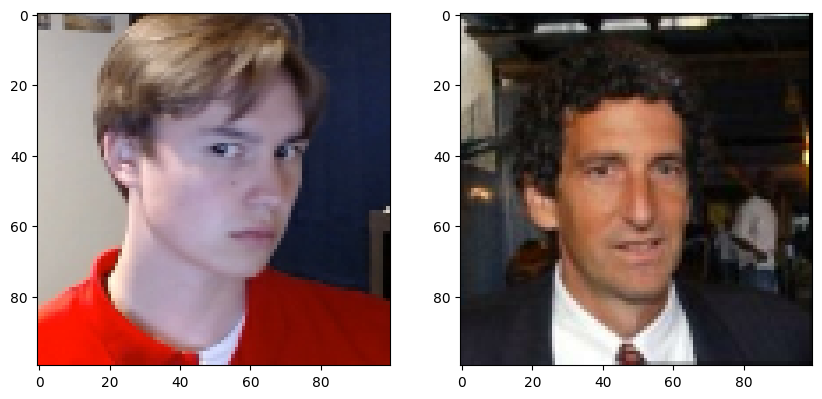

In [71]:
# visual results
# Set plot size 
plt.figure(figsize=(10,8))

# Set first subplot
plt.subplot(1,2,1)
plt.imshow(test_input[0])

# Set second subplot
plt.subplot(1,2,2)
plt.imshow(test_val[0])

# Renders cleanly
plt.show()

### Visualize a test pair
- Shows a side-by-side pair from the test batch to qualitatively assess similarity.

In [62]:
# Save Model
siamese_model.save('siamesemodelv2.h5')

### Save trained model
- Persists the `SiameseNetwork` as `siamesemodelv2.h5` for later loading and inference.

In [63]:
siamese_model = tf.keras.models.load_model('siamesemodelv2.h5', 
                                   custom_objects={'L1Dist':L1Dist, 'BinaryCrossentropy':tf.losses.BinaryCrossentropy})

### Reload model
- Loads the saved H5 model and registers the custom `L1Dist` layer and loss class for compatibility.

In [64]:
y_true

array([0., 0., 0., 1., 1., 1., 1., 1., 1., 0., 1., 0., 1., 1., 0., 0.],
      dtype=float32)

### Reuse labels
- Keeps the test labels in view while validating predictions from the reloaded model.

In [65]:
# Make predictions with reloaded model
siamese_model.predict([test_input, test_val])
[1 if prediction > 0.5 else 0 for prediction in yhat ]

1/1 [==============================] - 0s 57ms/step


[0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0]

### Predictions with reloaded model
- Verifies that loading from disk reproduces similar predictions and thresholded decisions.

In [66]:
# View model summary
siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_img (InputLayer)    [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 4096)         38960448    ['input_img[0][0]',              
                                                                  'validation_img[0][

### Final model summary
- Confirms architecture and parameters before moving to live verification.

In [67]:
#verification function
def run_verify(model, detection_threshold, verification_threshold):
    results = []
    for image in os.listdir(os.path.join('application_data', 'verification_images')):
        input_img = preproccess(os.path.join('application_data', 'input_image', 'input_image.jpg'))
        validation_img = preproccess(os.path.join('application_data', 'verification_images', image))
        
        # Make Predictions 
        result = model.predict(list(np.expand_dims([input_img, validation_img], axis=1)))
        results.append(result)
    
    # Detection Threshold: Metric above which a prediciton is considered positive 
    detection = np.sum(np.array(results) > detection_threshold)
    
    # Verification Threshold: Proportion of positive predictions / total positive samples 
    verification = detection / len(os.listdir(os.path.join('application_data', 'verification_images'))) 
    verified = verification > verification_threshold
    
    return results, verified

### Verification routine
- For each image in `application_data/verification_images`, compares it to `application_data/input_image/input_image.jpg`.
- Aggregates results using a detection threshold (per-image) and a verification threshold (proportion positive).

In [69]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()
    frame = frame[150:150+250,125:125+250,:]
    
    cv2.imshow('Verification', frame)
    
    # Verification trigger
    if cv2.waitKey(10) & 0xFF == ord('v'):

        cv2.imwrite(os.path.join('application_data', 'input_image', 'input_image.jpg'), frame)
        # Run verification
        results, verified = run_verify(siamese_model, 0.5, 0.5)
        print(verified)
    
    if cv2.waitKey(10) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

1/1 [==============================] - 0s 9ms/step
True
1/1 [==============================] - 0s 9ms/step
False
1/1 [==============================] - 0s 9ms/step
True


### Live verification loop
- Streams the cropped webcam feed and listens for keys:
  - `v`: saves the current crop as the input image and runs verification.
  - `q`: quits the loop.
- Prints a boolean `verified` result based on thresholds.

### Next steps
- Tune thresholds using ROC/PR curves.
- Add data augmentation and harder negatives.
- Consider contrastive or triplet losses for alternative training regimes.